In [1]:
%load_ext autoreload
%autoreload 2

# %config InlineBackend.figure_formats = ['svg']

from IPython.display import display, Markdown

import sys, os
sys.path.insert(0, '../py_scripts')

import numpy as np
import scipy as sp
import pandas as pd
import numpy.random as rand
import scipy.stats as stats


import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time
import glob
import pickle

import noise_models as noise
import thermo_models as thermo

import fig_plot as fplot
import model_fitting as fit

sns.set(context='talk', font_scale=1.0, color_codes=True, palette='deep', style='ticks', 
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':100, 'text.usetex':False})

This file uses the model parameters found from fitting to predict the antibody distributions for the phosphorylated substrate.

In [2]:
# label = "21_10_15_highgating"
# label = "21_10_15_highgating_regularize"
label = "21_10_15_medhighgating"
# label = "22_01_20"
# label = "22_01_20_noGFPexpressionshift"


df_params = pd.read_csv("../data/"+label+"/model_params.csv", sep=',', engine='python', index_col='name')

display(df_params)

,val,val_min,val_max
name,,,
bg_phospho_rate,-1.250144,-1.378218,-1.122443
kinase_dead,-8.000000,-8.000000,-1.538840
L+A,-1.917885,-8.000000,3.433166
kinase_wt,0.734443,0.530196,0.956288
kinase_non-binding,6.444474,5.874562,7.550062
375,-3.010553,-8.000000,-0.838085
419,-0.487141,-0.847159,-0.128367
E+A,2.493257,-8.000000,4.964686
E+E,5.822153,5.314336,6.353396


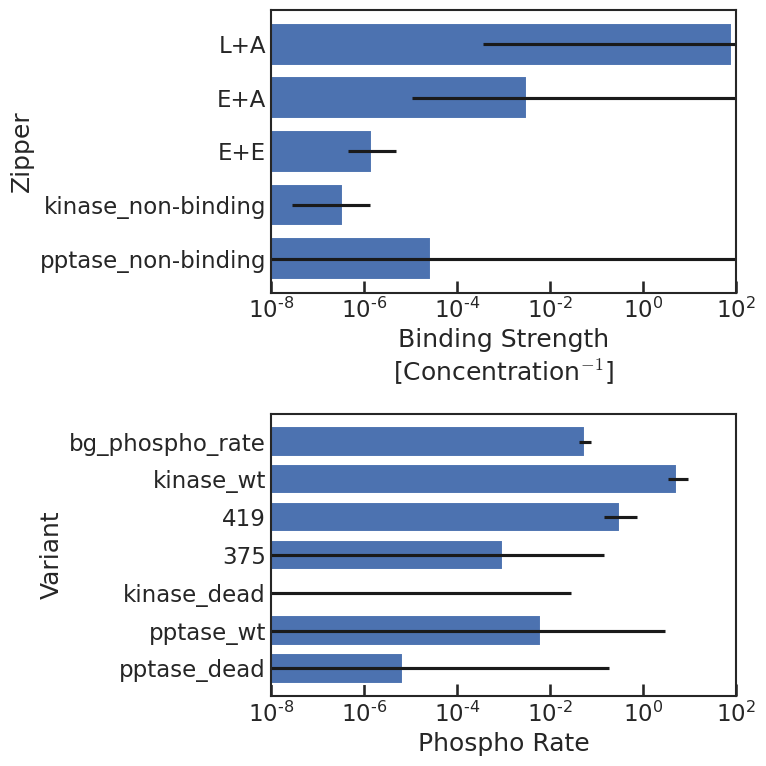

In [3]:
fig = plt.figure(figsize=(8, 8))

ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)


ax = ax1

labels = ['L+A', 'E+A', 'E+E', 'kinase_non-binding', 'pptase_non-binding'][::-1]

vals = 1.0 / 10**df_params.loc[labels, 'val']

y_low = vals-1.0/10**df_params.loc[labels, 'val_max']
y_high = 1.0/10**df_params.loc[labels, 'val_min']-vals

ax.barh(labels, vals, xerr=(y_low, y_high))



ax.set_xscale('log')
ax.set_ylabel("Zipper")
ax.set_xlabel("Binding Strength\n[Concentration$^{-1}$]")

ax.set_xlim(1e-8, 1e2)

ax = ax2

labels = ['bg_phospho_rate', 'kinase_wt', '419', '375', 'kinase_dead', 'pptase_wt', 'pptase_dead'][::-1]

vals = 10**df_params.loc[labels, 'val']

y_low = vals-10**df_params.loc[labels, 'val_min']
y_high = 10**df_params.loc[labels, 'val_max']-vals

ax.barh(labels, vals, xerr=(y_low, y_high))



ax.set_xscale('log')
ax.set_ylabel("Variant")
ax.set_xlabel("Phospho Rate")

ax.set_xlim(1e-8, 1e2)


plt.tight_layout()

plt.show()

In [4]:
df_data = pd.read_csv("../data/"+label+"/model_predictions.csv", sep='\s*,\s*', index_col=[0, 1])
display(df_data)

df_dataset_key = pd.read_csv("../data/"+label+"/dataset_key.csv", sep='\s*,\s*', engine='python').set_index("exp_name")
display(df_dataset_key)

df_anti2GFP_key = pd.read_csv("../data/"+label+"/MOCU_key.csv", sep='\s*,\s*', engine='python').set_index("component")
display(df_anti2GFP_key)

df_phospho_empty = pd.read_csv("../data/{}/{}.csv".format(label, df_anti2GFP_key.loc['empty_phospho', 'file_name']))
empty_anti_vals = df_phospho_empty[df_anti2GFP_key.loc['empty_phospho', 'anti_col_name']].values
empty_anti_vals = empty_anti_vals[empty_anti_vals > 0.0]
empty_GFP_vals = df_phospho_empty[df_anti2GFP_key.loc['empty_phospho', 'GFP_col_name']].values
empty_GFP_vals = empty_GFP_vals[empty_GFP_vals > 0.0]

df_phospho_nonempty = pd.read_csv("../data/{}/{}.csv".format(label, df_anti2GFP_key.loc['phospho', 'file_name']))
nonempty_anti_vals = df_phospho_nonempty[df_anti2GFP_key.loc['phospho', 'anti_col_name']].values
nonempty_anti_vals = nonempty_anti_vals[nonempty_anti_vals > 0.0]
nonempty_GFP_vals = df_phospho_nonempty[df_anti2GFP_key.loc['phospho', 'GFP_col_name']].values
nonempty_GFP_vals = nonempty_GFP_vals[nonempty_GFP_vals > 0.0]


/projectnb/biophys/jrocks/.conda/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


kinase_anti_exp  substrate_anti_exp  \
exp_name       cell_index                                        
substrate_only 0                 79.178284         2212.525146   
               1                 86.252625         4954.513184   
               2                 10.157516         3487.114746   
               3                 96.854454          253.888428   
               4                118.221375          584.118408   
...                                    ...                 ...   
two_layer      8387             538.831848          509.163879   
               8388             502.579071          645.187561   
               8389             172.194412          680.760376   
               8390             129.300323          687.451172   
               8391             223.427887          396.494293   

                           phospho_anti_exp  pptase_anti_exp  \
exp_name       cell_index                                      
substrate_only 0                 133.354218     1.000000e-08   
               1                 112.124626     1.000000e-08   
               2                 119.673706     1.000000e-08   
               3                 100.082169     1.000000e-08   
               4                  39.466415     1.000000e-08   
...                                     ...              ...   
two_layer      8387              704.758423     7.326640e+01   
               8388             1412.649902     2.589982e+02   
               8389             2112.287354     2.860129e+02   
               8390             1222.891113     5.057090e+02   
               8391              746.775269     8.001365e+01   

                           kinase2_anti_exp  kinase2phospho_anti_exp  \
exp_name       cell_index                                              
substrate_only 0               1.000000e-08             1.000000e-08   
               1               1.000000e-08             1.000000e-08   
               2               1.000000e-08             1.000000e-08   
               3               1.000000e-08             1.000000e-08   
               4               1.000000e-08             1.000000e-08   
...                                     ...                      ...   
two_layer      8387            5.938093e+02             1.440575e+03   
               8388            9.887302e+02             2.151519e+03   
               8389            1.987362e+03             1.990649e+03   
               8390            8.492007e+02             1.806211e+03   
               8391            5.518015e+02             1.658656e+03   

                           phospho_GFP_infer  phospho_conc_infer  \
exp_name       cell_index                                          
substrate_only 0                  975.604414                 0.0   
               1                 1749.659563                 0.0   
               2                  336.290265                 0.0   
               3                   83.811712                 0.0   
               4                  310.791469                 0.0   
...                                      ...                 ...   
two_layer      8387              4883.559992                 0.0   
               8388             29577.775821                 0.0   
               8389             14195.129606                 0.0   
               8390             13589.528204                 0.0   
               8391              9974.198113                 0.0   

                           substrate_GFP_infer  substrate_conc_infer  ...  \
exp_name       cell_index                                             ...   
substrate_only 0                  21241.623933                   0.0  ...   
               1                  35254.937260                   0.0  ...   
               2                  21448.420977                   0.0  ...   
               3                   2265.473029                   0.0  ...   
               4                  11529.644980     

,file_name,model,kinase_variant,kinase_zipper,pptase_variant,pptase_zipper,kinase2_variant,kinase2_zipper,substrate_col,phospho_col,kinase_col,pptase_col,kinase2_col,kinase2phospho_col,KS_stat
exp_name,,,,,,,,,,,,,,,
substrate_only,127,substrate_only,NaN,NaN,NaN,NaN,NaN,NaN,ST,SpT,WT,NaN,NaN,NaN,0.094982
non-pplatable,174,non-pplatable,174,L+A,NaN,NaN,NaN,NaN,ST,SpT,WT,NaN,NaN,NaN,0.143623
kinase_dead,421,push,kinase_dead,L+A,NaN,NaN,NaN,NaN,ST,SpT,WT,NaN,NaN,NaN,0.214869
kinase_non-binding,RR+A,push,kinase_wt,kinase_non-binding,NaN,NaN,NaN,NaN,ST,SpT,WT,NaN,NaN,NaN,0.081419
kinase_variant_375,375,push,375,L+A,NaN,NaN,NaN,NaN,ST,SpT,WT,NaN,NaN,NaN,0.072310
kinase_variant_419,419,push,419,L+A,NaN,NaN,NaN,NaN,ST,SpT,WT,NaN,NaN,NaN,0.050428
kinase_zipper_E+A,E+A,push,kinase_wt,E+A,NaN,NaN,NaN,NaN,ST,SpT,WT,NaN,NaN,NaN,0.071571
kinase_zipper_E+E,E+E,push,kinase_wt,E+E,NaN,NaN,NaN,NaN,ST,SpT,WT,NaN,NaN,NaN,0.059227
kinase_zipper_L+A,L+A,push,kinase_wt,L+A,NaN,NaN,NaN,NaN,ST,SpT,WT,NaN,NaN,NaN,0.251003


,file_name,anti_col_name,GFP_col_name
component,,,
empty_substrate,BFP(empty cell),ST,GFP
empty_phospho,BFP(empty cell),SpT,GFP
empty_kinase,BFP(empty cell),WT,GFP
empty_pptase,BFP(empty cell),pptase,GFP
empty_kinase2,BFP(empty cell),ST,GFP
empty_kinase2phospho,BFP(empty cell),SpT,GFP
substrate,ST:SpT MOCU,ST,GFP
phospho,ST:SpT MOCU,SpT,GFP
kinase,WT MOCU,WT,GFP


KS for empty and activated controls: 0.7615423179241427


/projectnb/biophys/jrocks/.conda/envs/default/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/projectnb/biophys/jrocks/.conda/envs/default/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


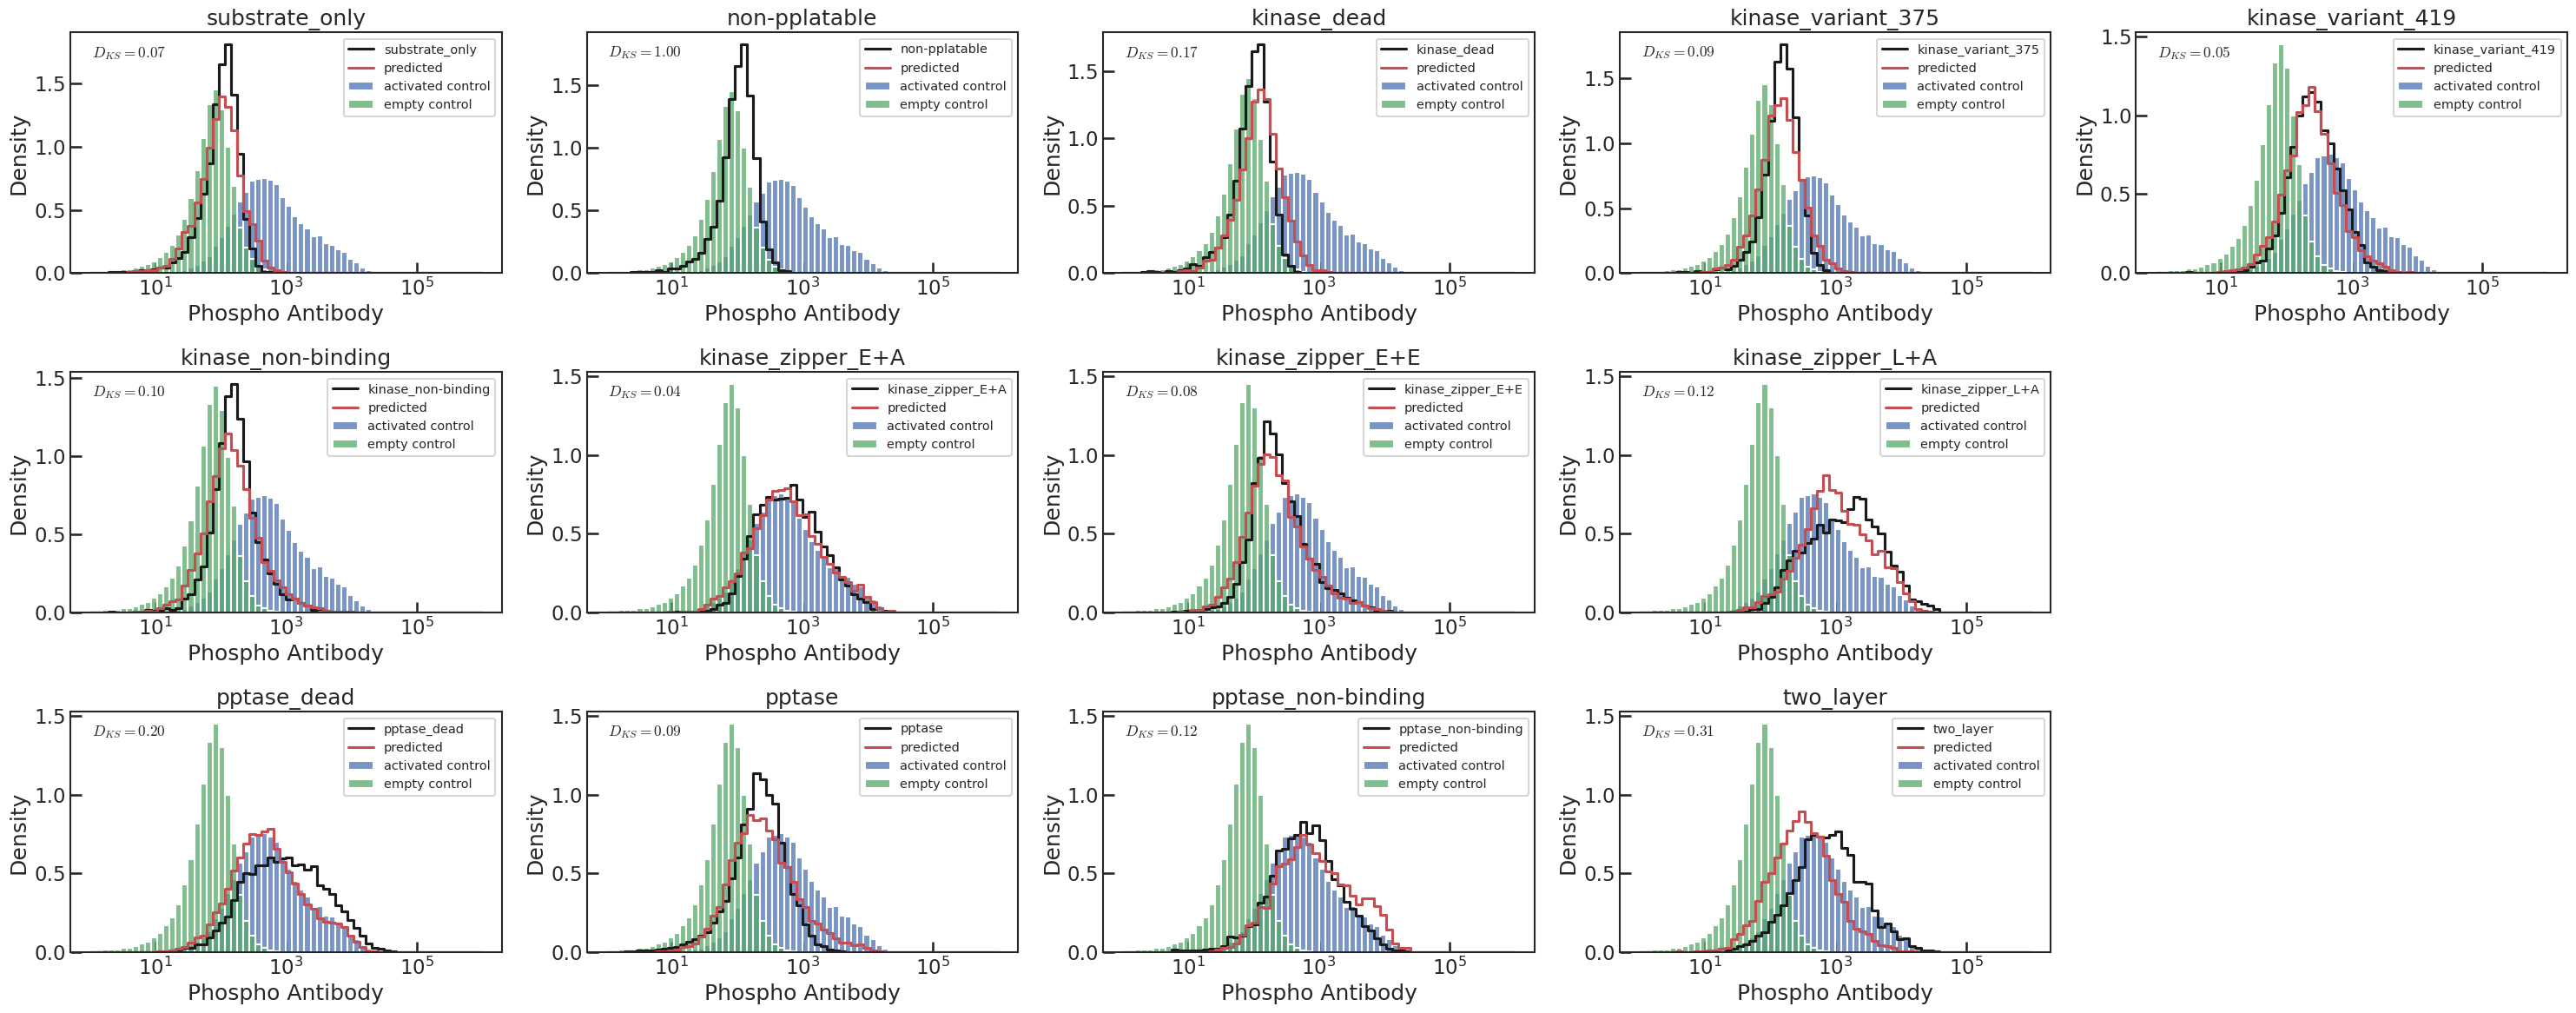

In [5]:

(ks, pval) = stats.ks_2samp(nonempty_anti_vals, empty_anti_vals)

print("KS for empty and activated controls:", ks)

binrange = (0, 6)

fig = plt.figure(figsize=(30, 12))

# which data set to put on each axis
ax_dict = {'substrate_only': 1, 'non-pplatable': 2, 'kinase_dead': 3, 'kinase_variant_375': 4, 'kinase_variant_419': 5,
          'kinase_non-binding': 6, 'kinase_zipper_E+A': 7, 'kinase_zipper_E+E': 8, 'kinase_zipper_L+A': 9, 
           'pptase_dead': 11, 'pptase': 12, 'pptase_non-binding': 13, 'two_layer': 14}


for exp_name, row in df_dataset_key.iterrows():
        
    df_tmp = df_data.query("exp_name==@exp_name").dropna()
    
    ax = fig.add_subplot(3, 5, ax_dict[exp_name])
    
    ax.set_title(exp_name)
        
    sns.histplot(df_tmp['phospho_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label=exp_name, element='step', fill=False, color='k', stat='density')
    sns.histplot(df_tmp['phospho_anti_predict'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='predicted', element='step', fill=False, color='r', stat='density')
    sns.histplot(nonempty_anti_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='activated control', color='b', stat='density')
    sns.histplot(empty_anti_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')

    ax.set_xlabel("Phospho Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')
        
#     ax.set_yscale('log')

    (ks, pval) = stats.ks_2samp(df_tmp['phospho_anti_exp'], df_tmp['phospho_anti_predict'])
        
#     MSE = np.sum((np.log10(df_tmp['SpT_GFP_infer'])-np.log10(df_tmp['SpT_GFP_predict']))**2)
#     var = np.sum((np.log10(df_tmp['SpT_GFP_infer'])-np.log10(df_tmp['SpT_GFP_infer']).mean())**2)
#     R2 = 1 - MSE/var
        
    ax.text(0.05, 0.95, r"$D_{{KS}}={:.2f}$".format(ks), transform=ax.transAxes, fontsize='x-small', ha='left', va='top')
        
    
    df_dataset_key.loc[exp_name, 'KS_stat'] = ks
#     df_dataset_key.loc[exp_name, 'R2_stat'] = R2
    
plt.tight_layout()

plt.show()


In [6]:
df_dataset_key.to_csv("../data/"+label+"/dataset_key.csv", sep=',')

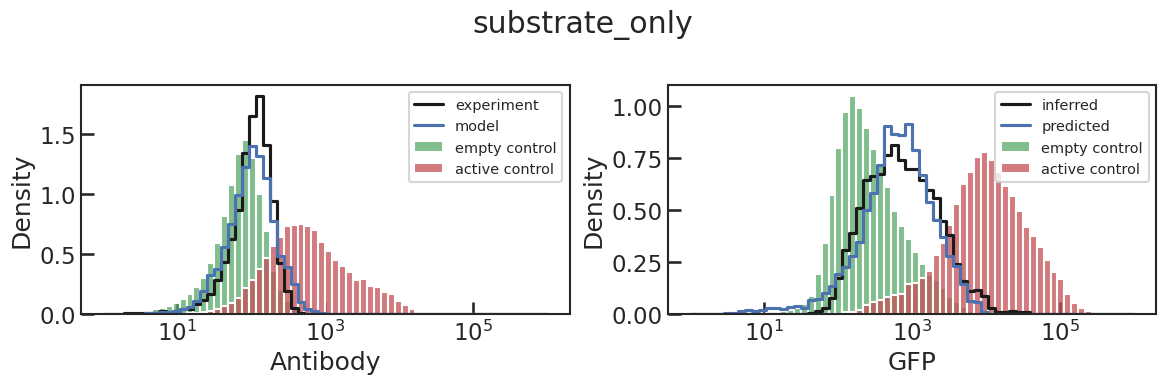

/projectnb/biophys/jrocks/.conda/envs/default/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/projectnb/biophys/jrocks/.conda/envs/default/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/projectnb/biophys/jrocks/.conda/envs/default/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/projectnb/biophys/jrocks/.conda/envs/default/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


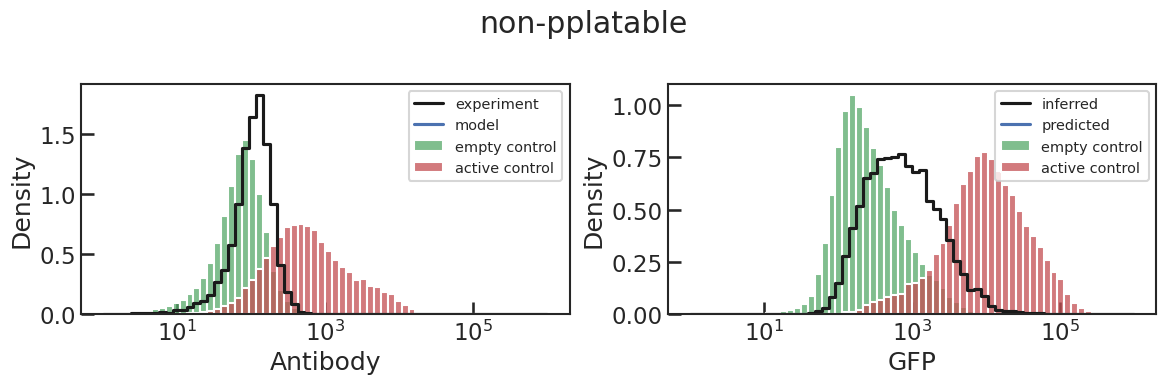

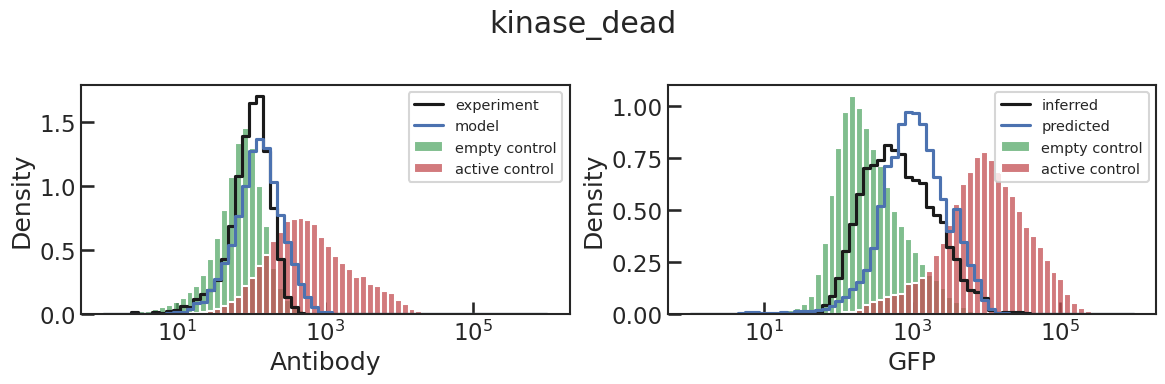

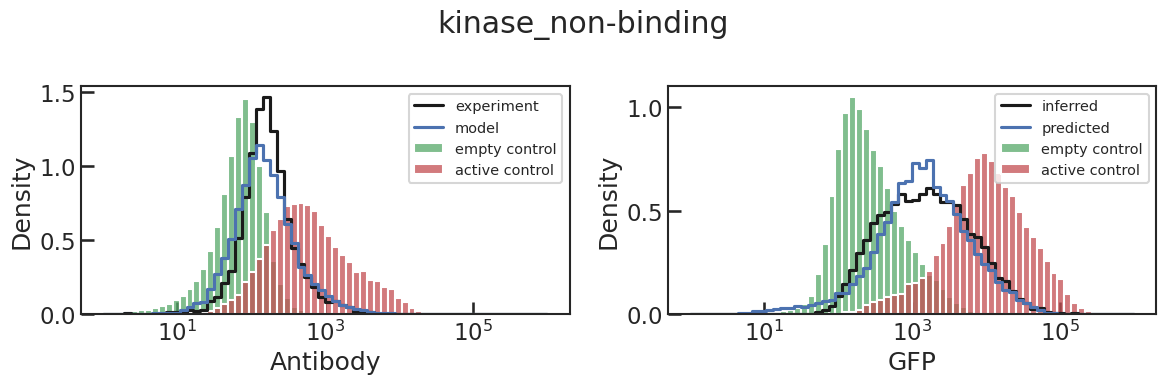

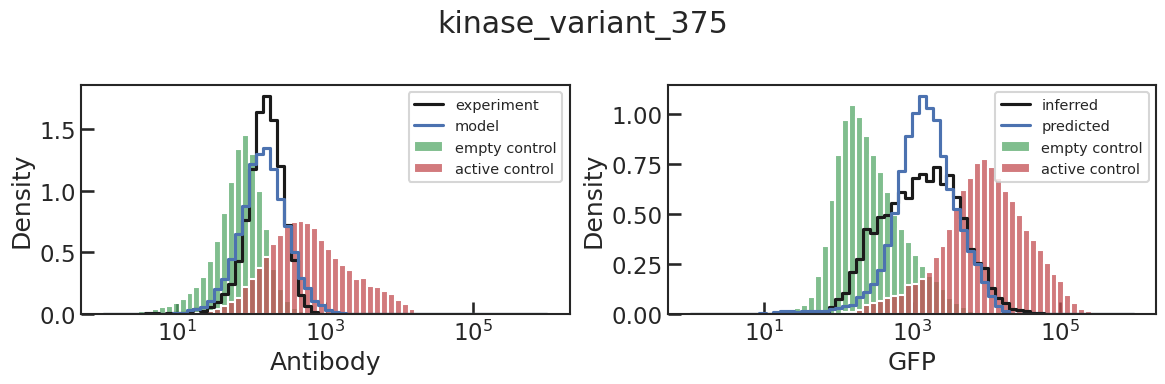

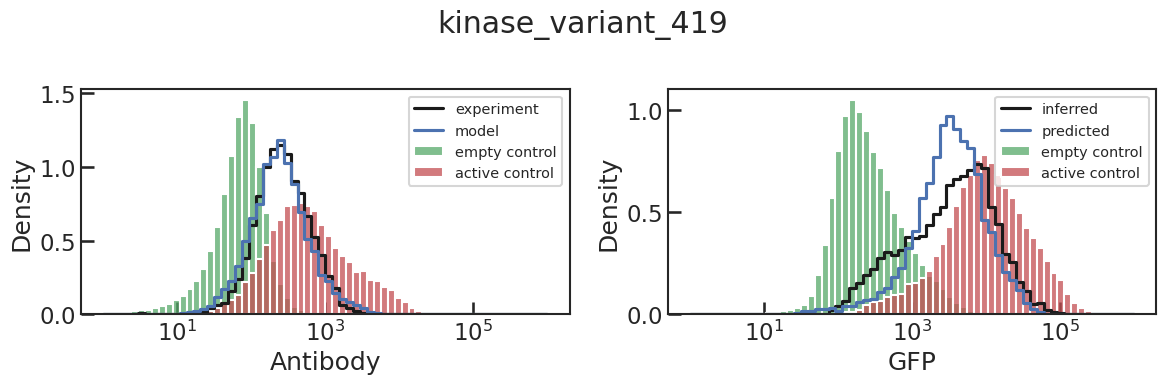

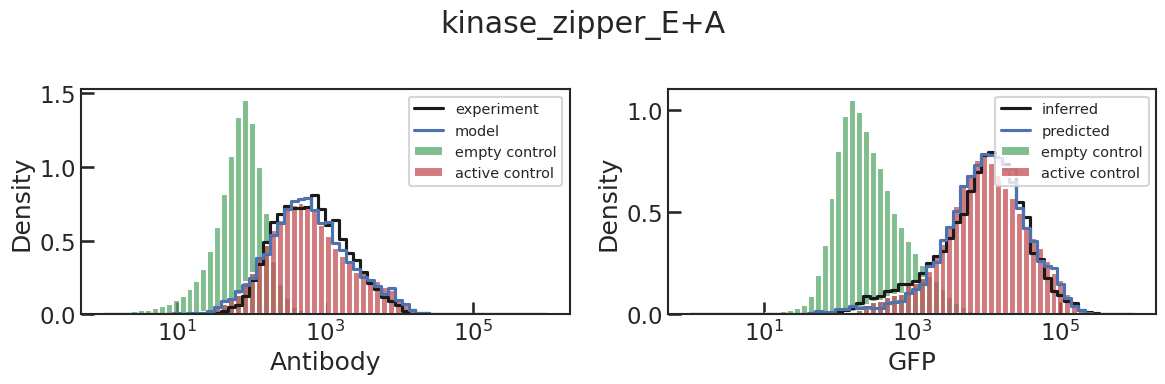

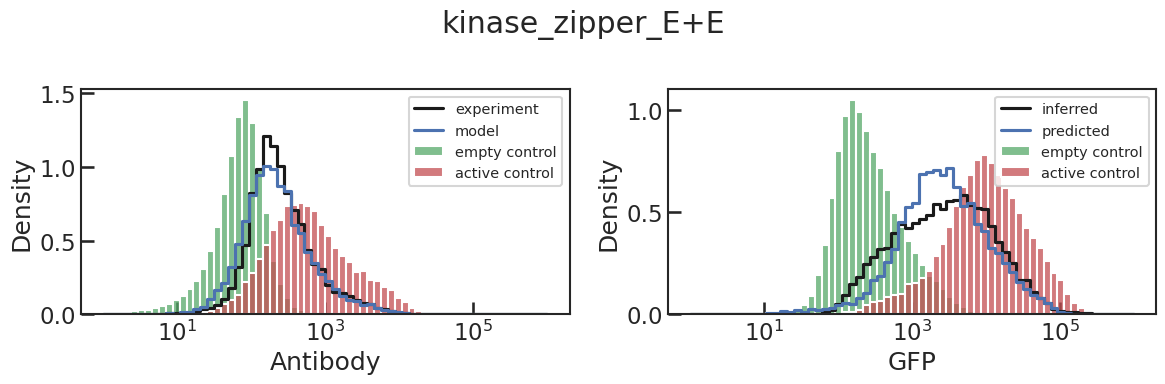

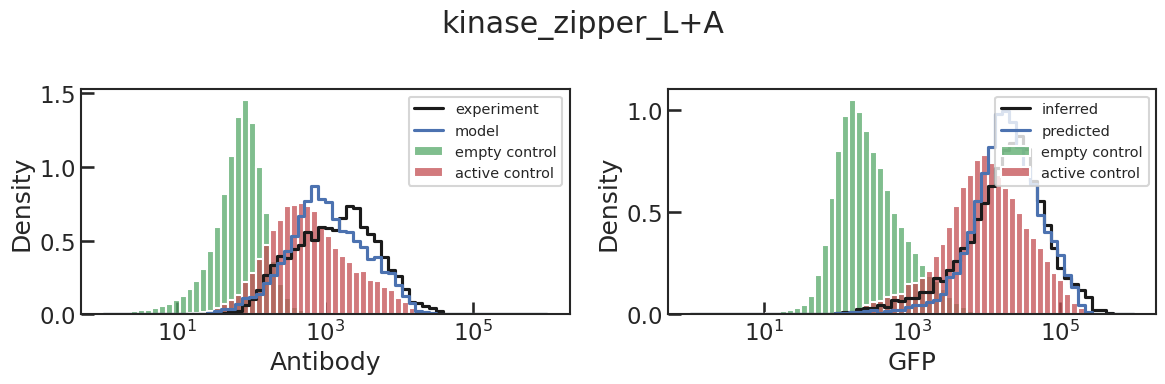

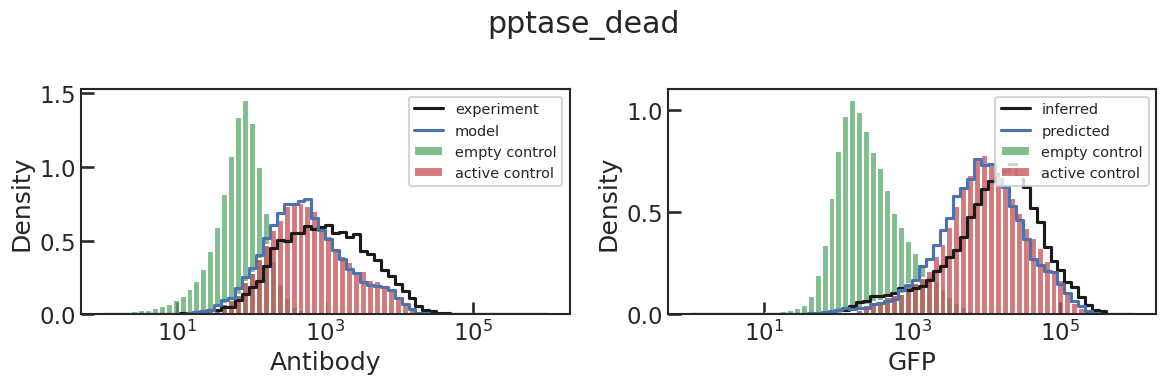

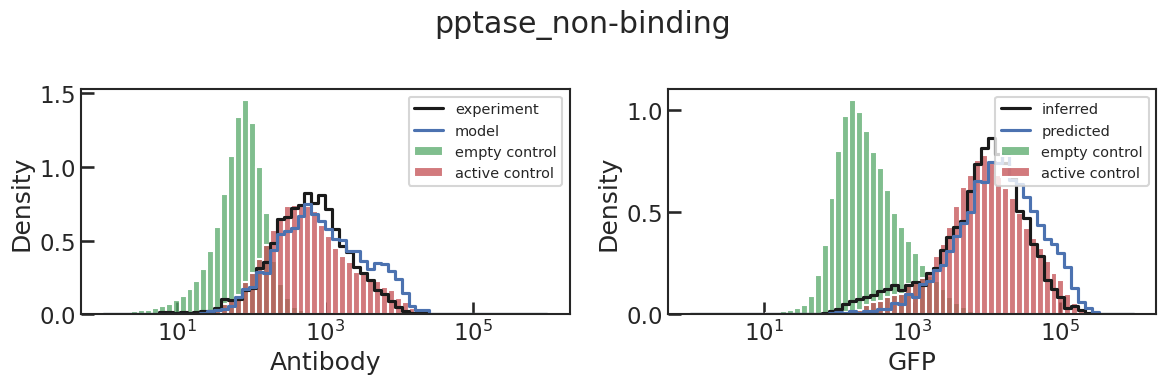

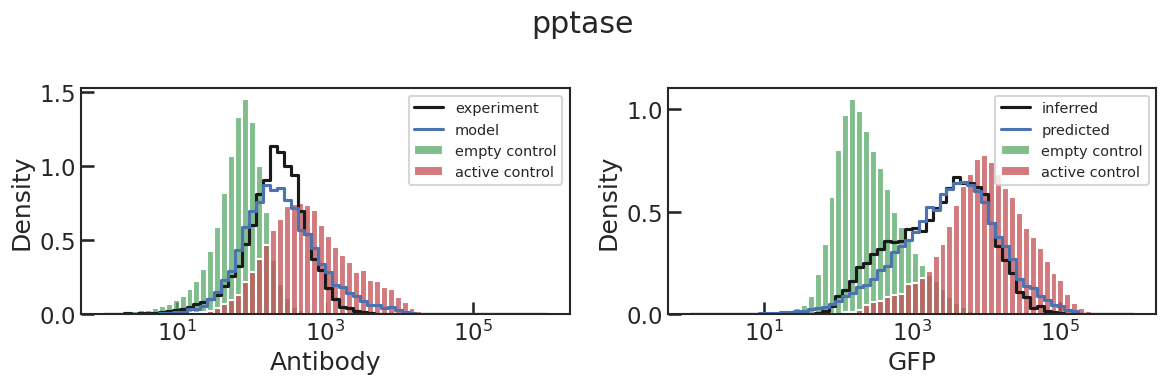

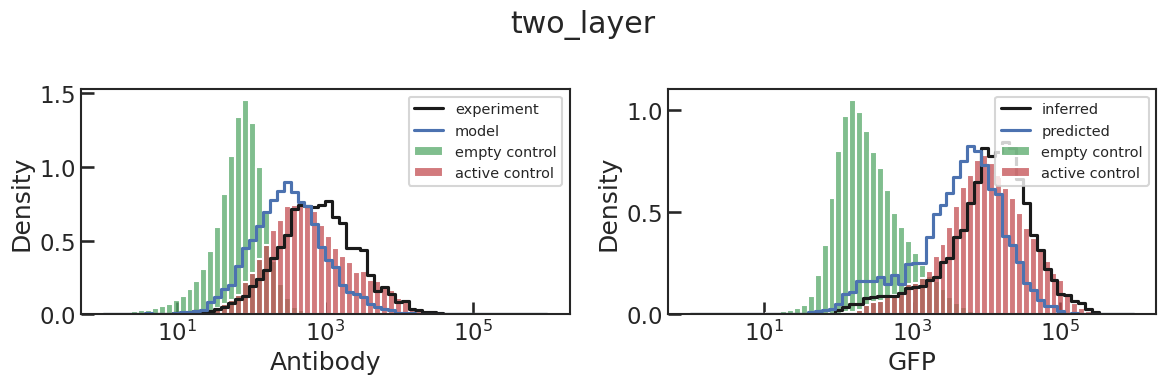

In [7]:

for exp_name, row in df_dataset_key.iterrows():
    
    df_tmp = df_data.query("exp_name==@exp_name").dropna()
    
    binrange = (0, 6)
        
    
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), squeeze=False)
    
    fig.suptitle(exp_name)
    
    #plot phospho in antibody and GFP units for exp and predicted
       

    ax = axes[0, 0]


    sns.histplot(empty_anti_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')
    sns.histplot(nonempty_anti_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='active control', color='r', stat='density')
    
    sns.histplot(df_data.loc[df_tmp.index, 'phospho_anti_exp'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='experiment', element='step', fill=False, color='k', stat='density')
    
    sns.histplot(df_data.loc[df_tmp.index, 'phospho_anti_predict'], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='model', element='step', fill=False, color='b', stat='density')

    ax.set_xscale('log')
    ax.set_xlabel("Antibody")

    ax.legend(loc='upper right', fontsize='xx-small')



    ax = axes[0, 1]

    sns.histplot(empty_GFP_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='empty control', color='g', stat='density')
    sns.histplot(nonempty_GFP_vals, binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='active control', color='r', stat='density')
    
    sns.histplot(df_tmp["phospho_GFP_infer"], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='inferred', element='step', fill=False, color='k', stat='density')
    
    sns.histplot(df_tmp["phospho_GFP_predict"], binrange=binrange, log_scale=True, bins=64, ax=ax, 
                 label='predicted', element='step', fill=False, color='b', stat='density')


    ax.set_xscale('log')
    ax.set_xlabel("GFP")

    ax.legend(loc='upper right', fontsize='xx-small')
    

    plt.tight_layout()
    plt.show()
        
                

    

/projectnb/biophys/jrocks/.conda/envs/default/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


total loss: inf


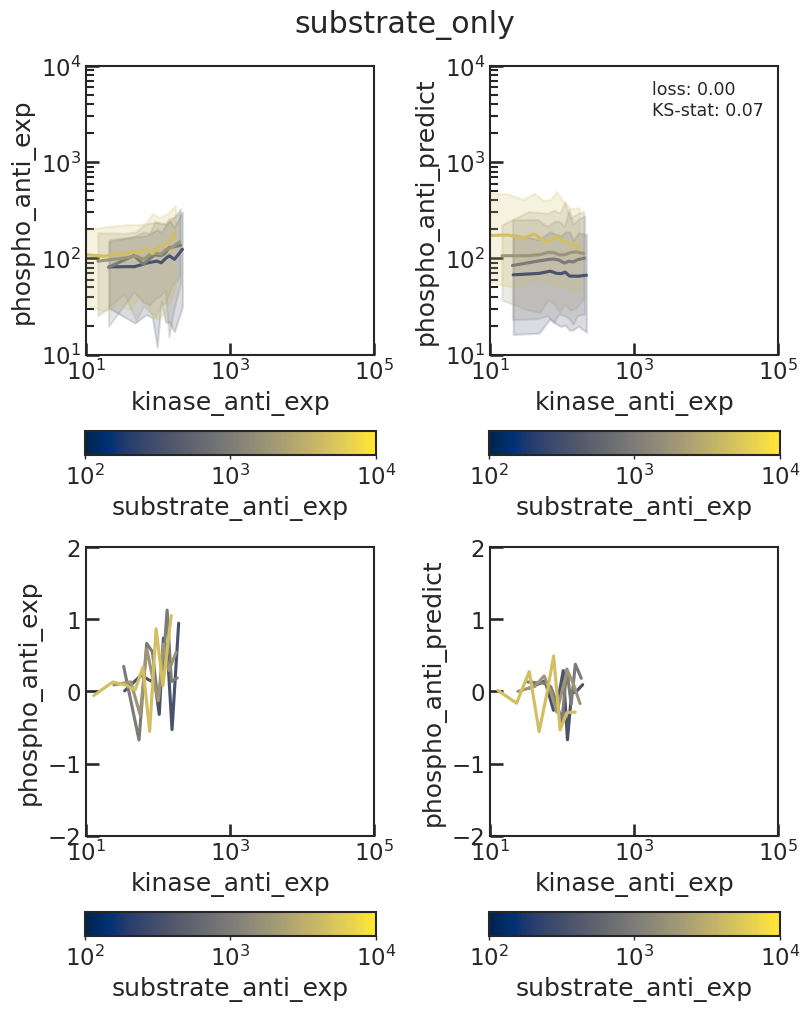

/projectnb/biophys/jrocks/.conda/envs/default/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/projectnb/biophys/jrocks/.conda/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
../py_scripts/fig_plot.py:423: RuntimeWarning: divide by zero encountered in log10
  dy = np.log10(y[1:]) - np.log10(y[0:len(y)-1])
../py_scripts/fig_plot.py:423: RuntimeWarning: invalid value encountered in subtract
  dy = np.log10(y[1:]) - np.log10(y[0:len(y)-1])
../py_scripts/fig_plot.py:423: RuntimeWarning: divide by zero encountered in log10
  dy = np.log10(y[1:]) - np.log10(y[0:len(y)-1])
../py_scripts/fig_plot.py:423: RuntimeWarning: invalid value encountered in subtract
  dy = np.log10(y[1:]) - np.log10(y[0:len(y)-1])
../py_scripts/fig_plot.py:423: RuntimeWarning: divide by zero encountered in log10
  dy = np.log10(

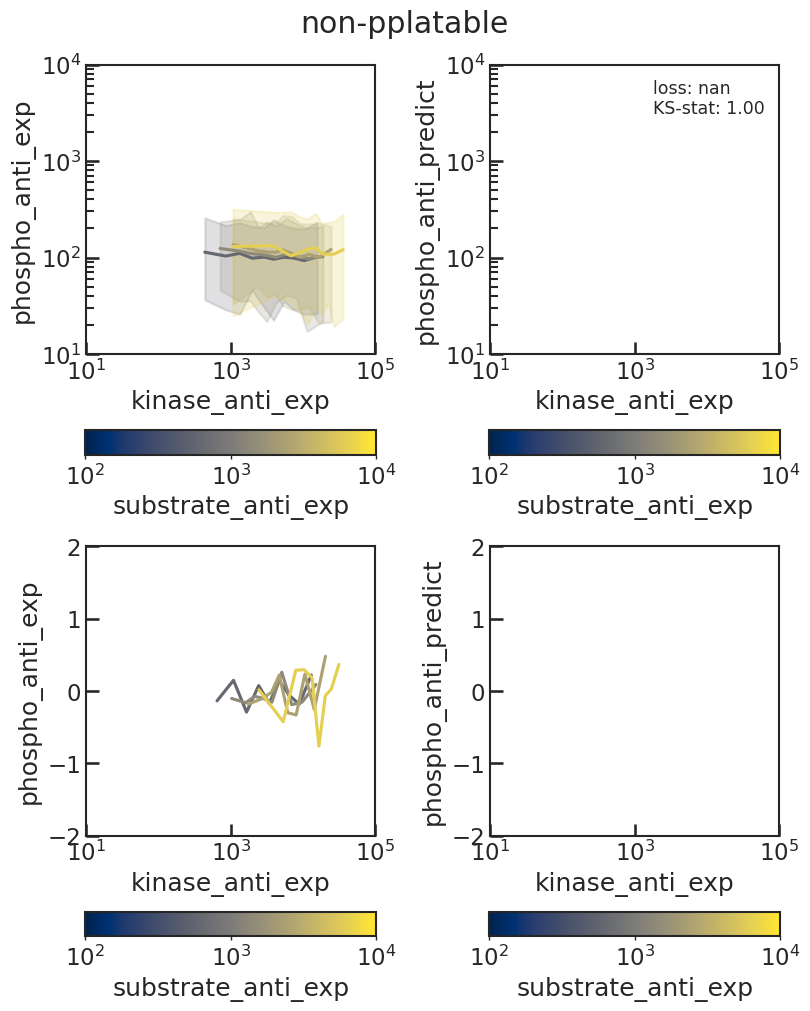

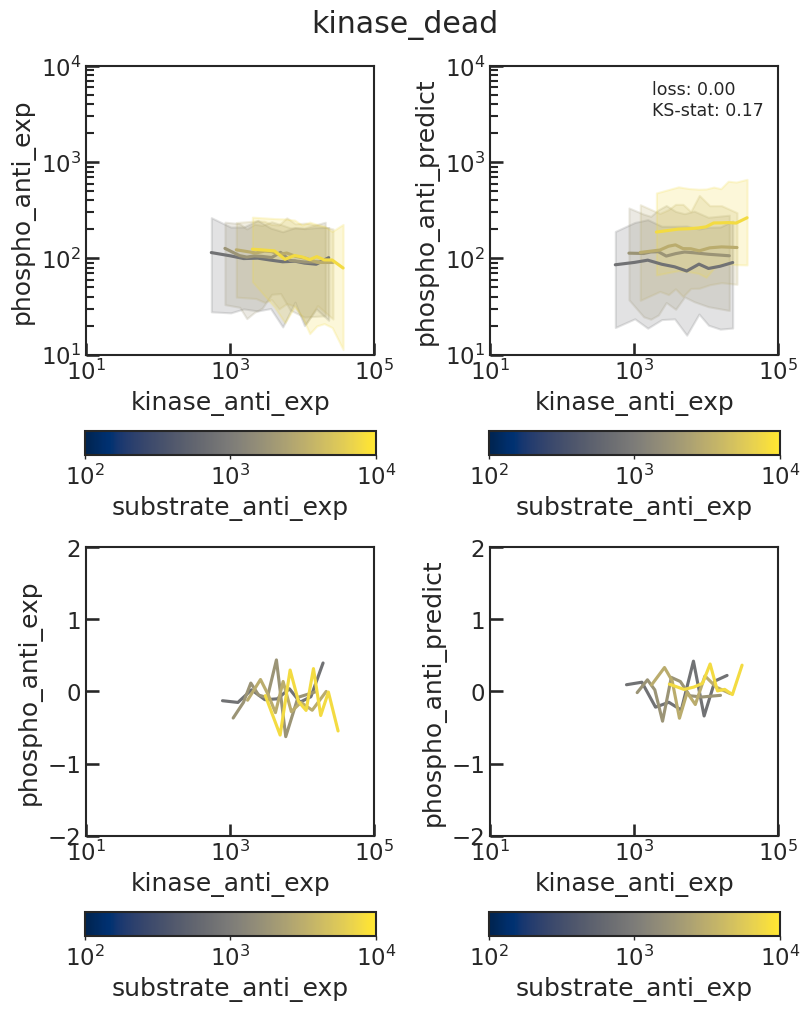

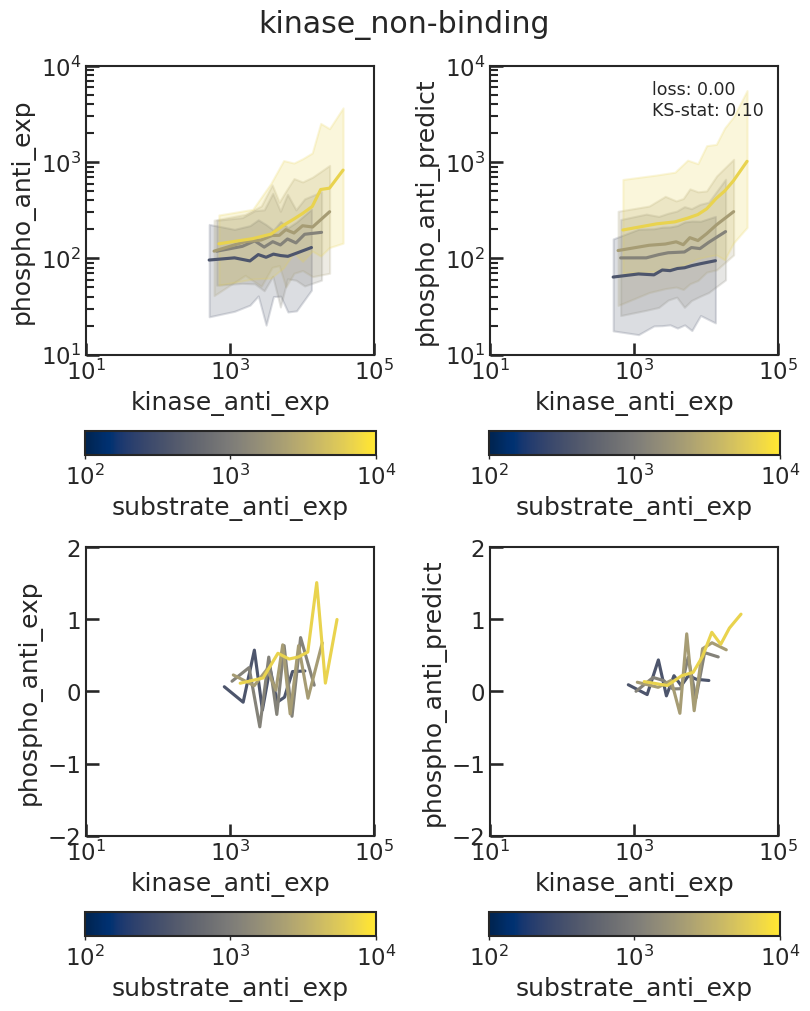

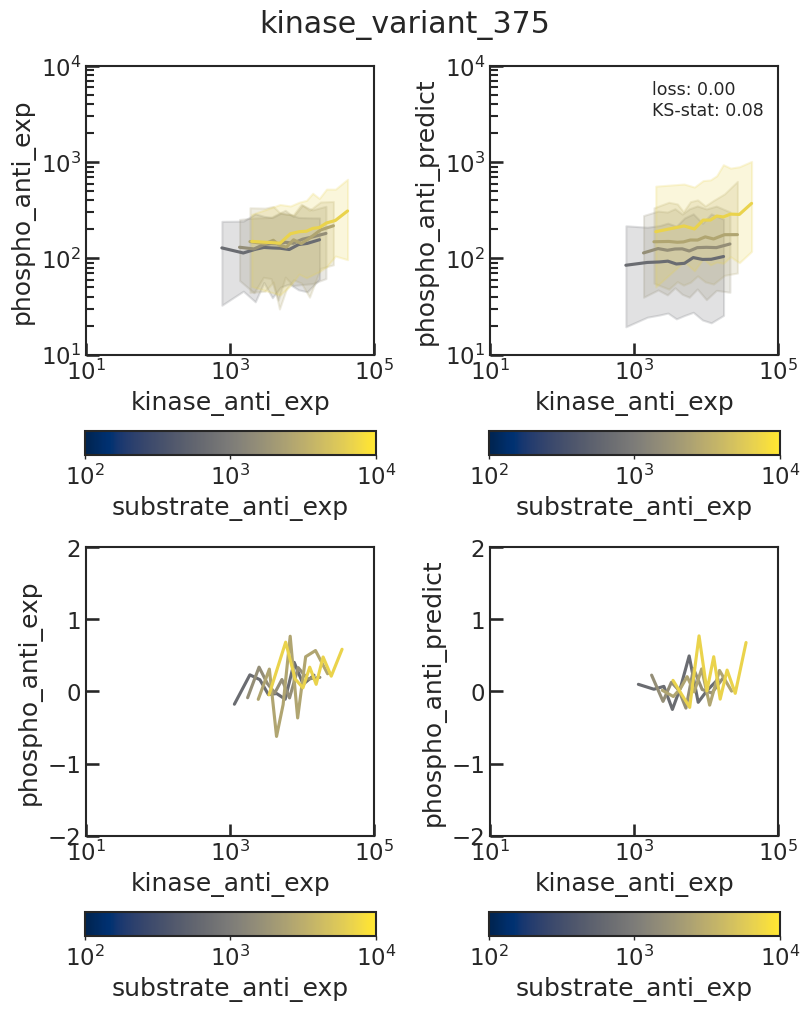

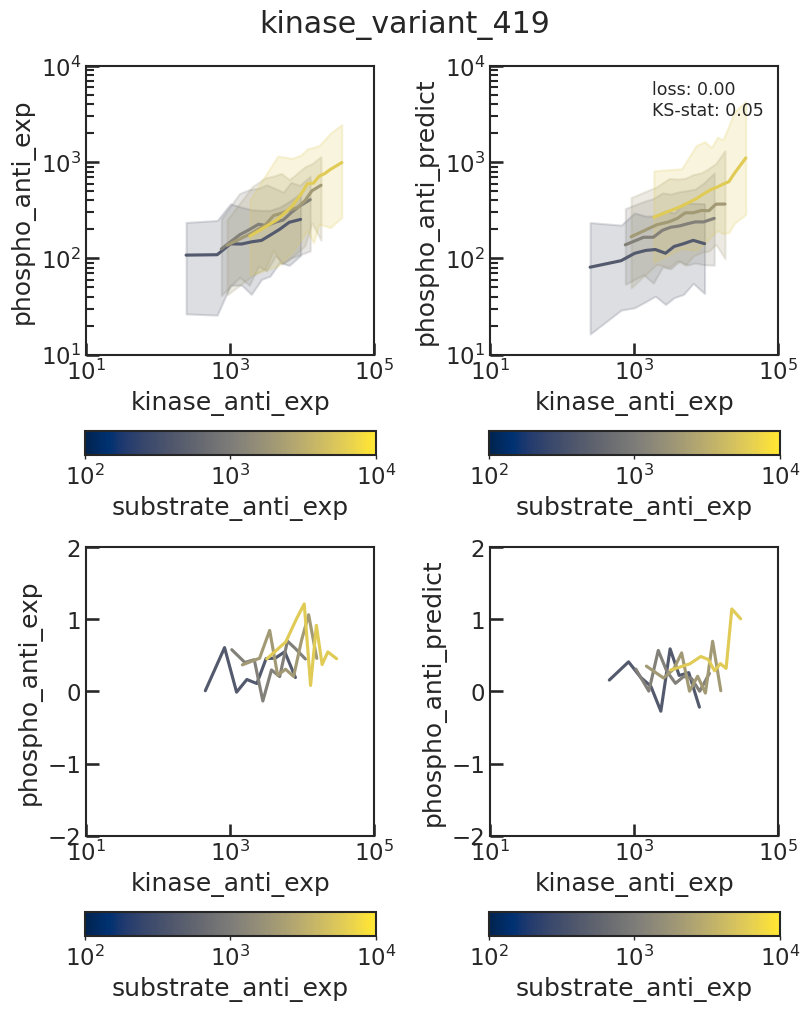

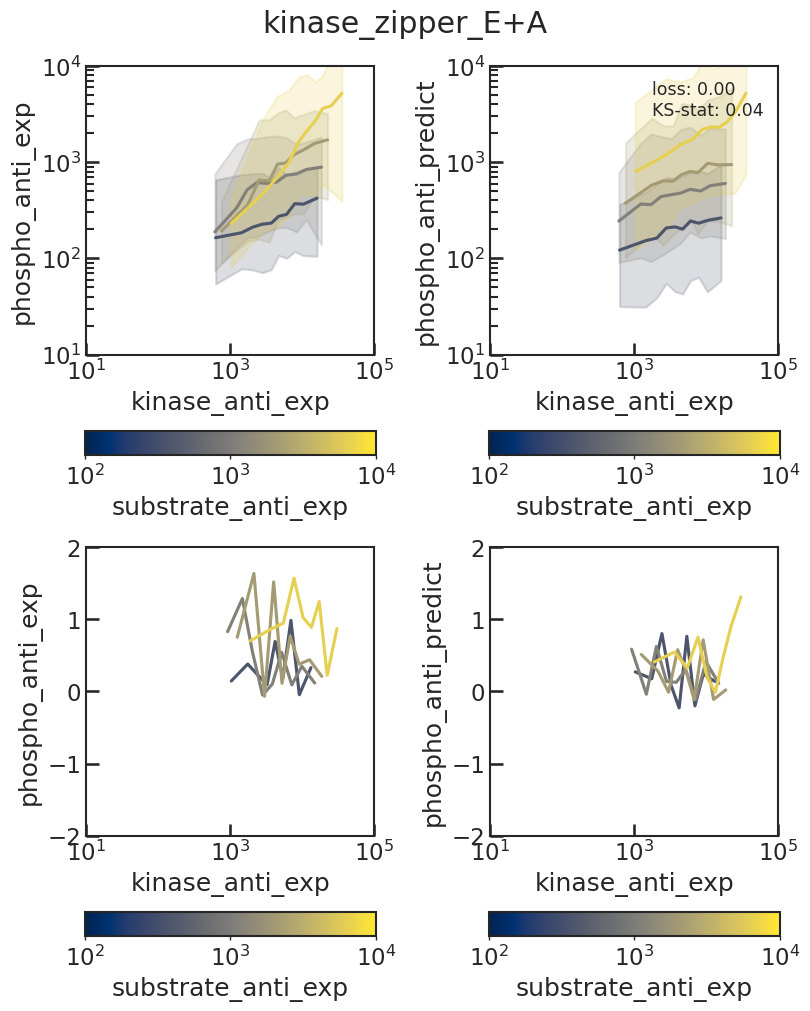

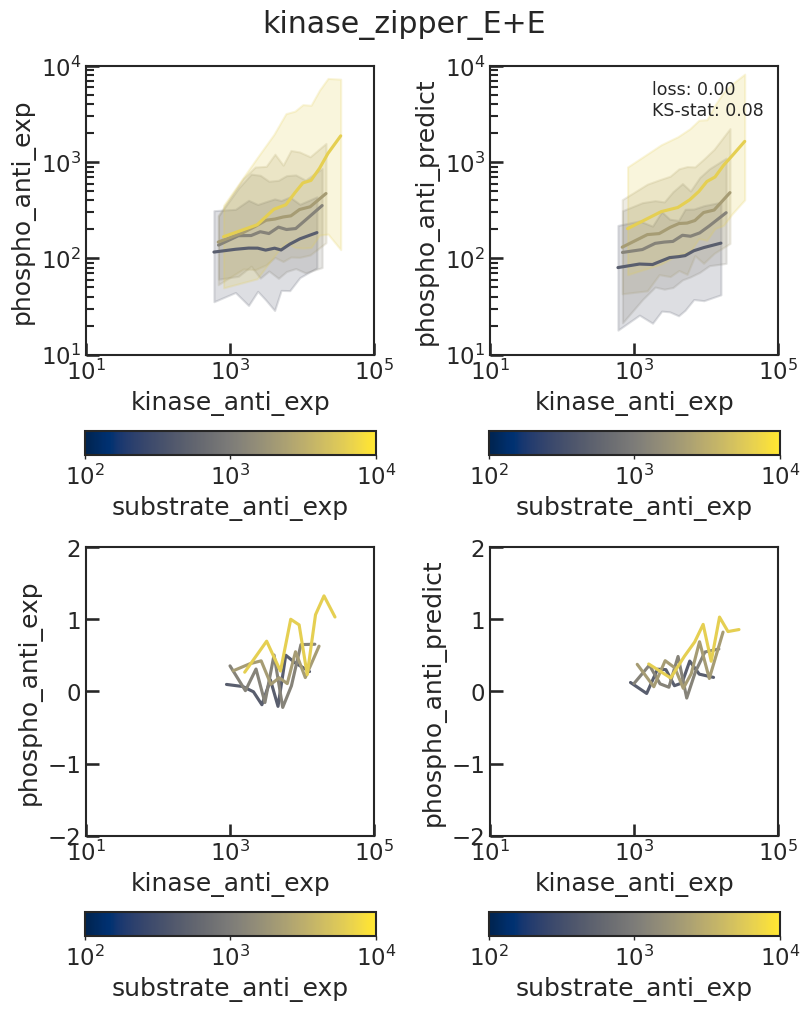

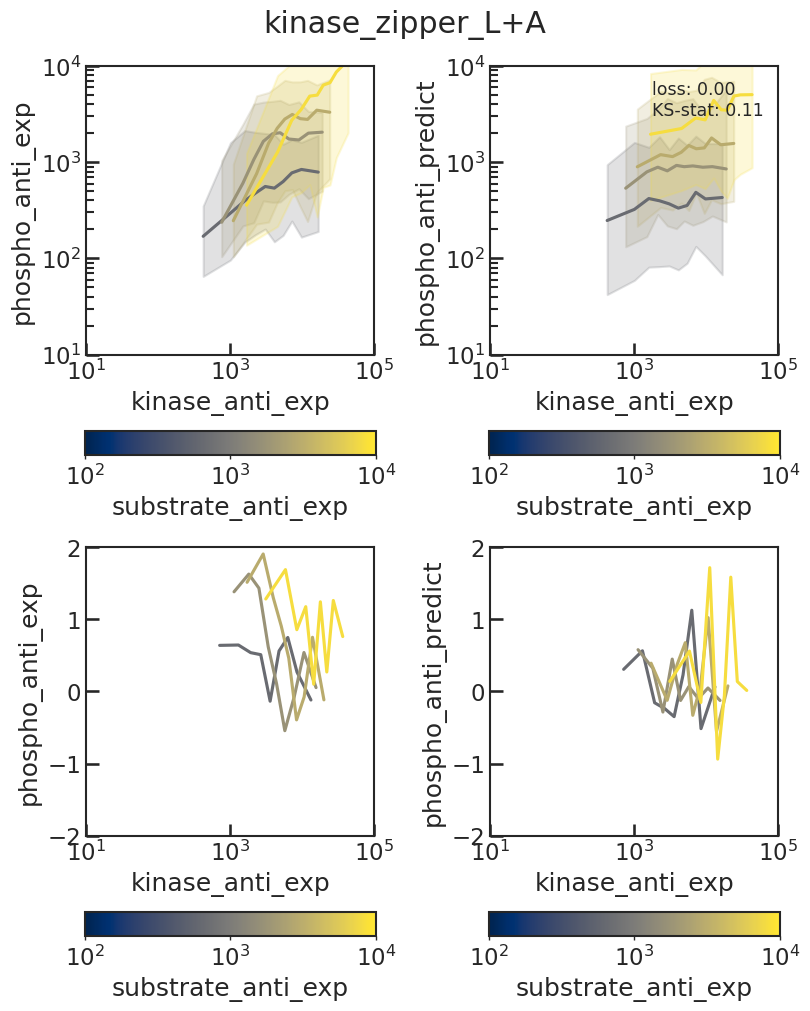

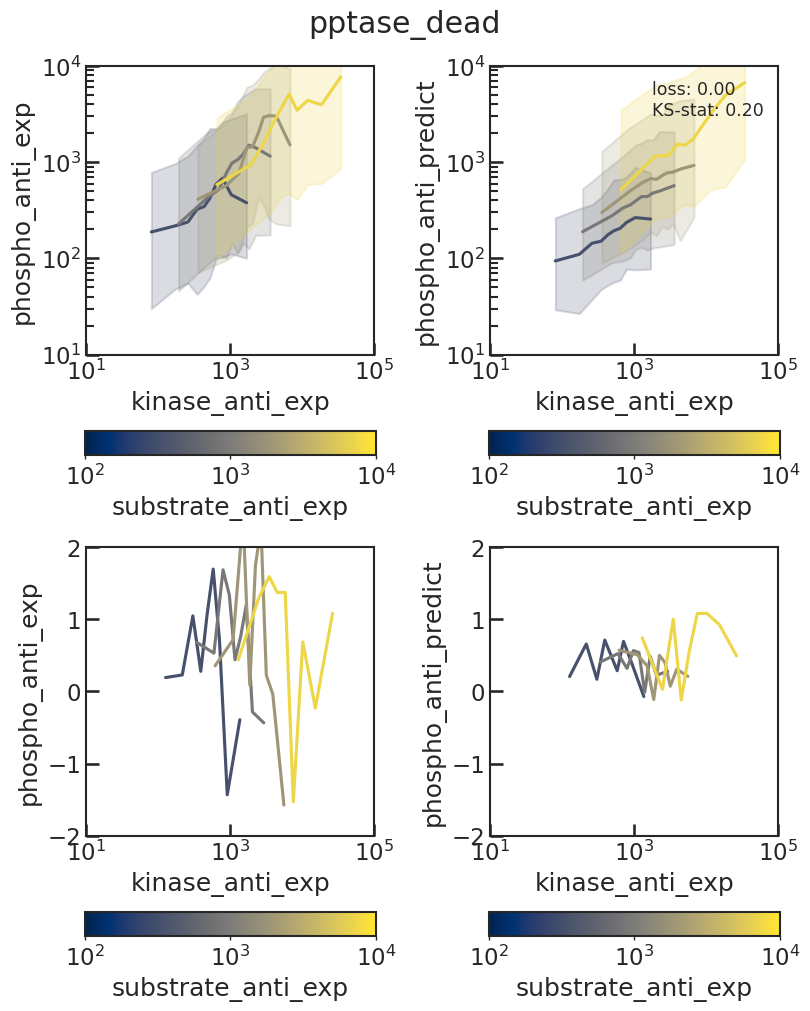

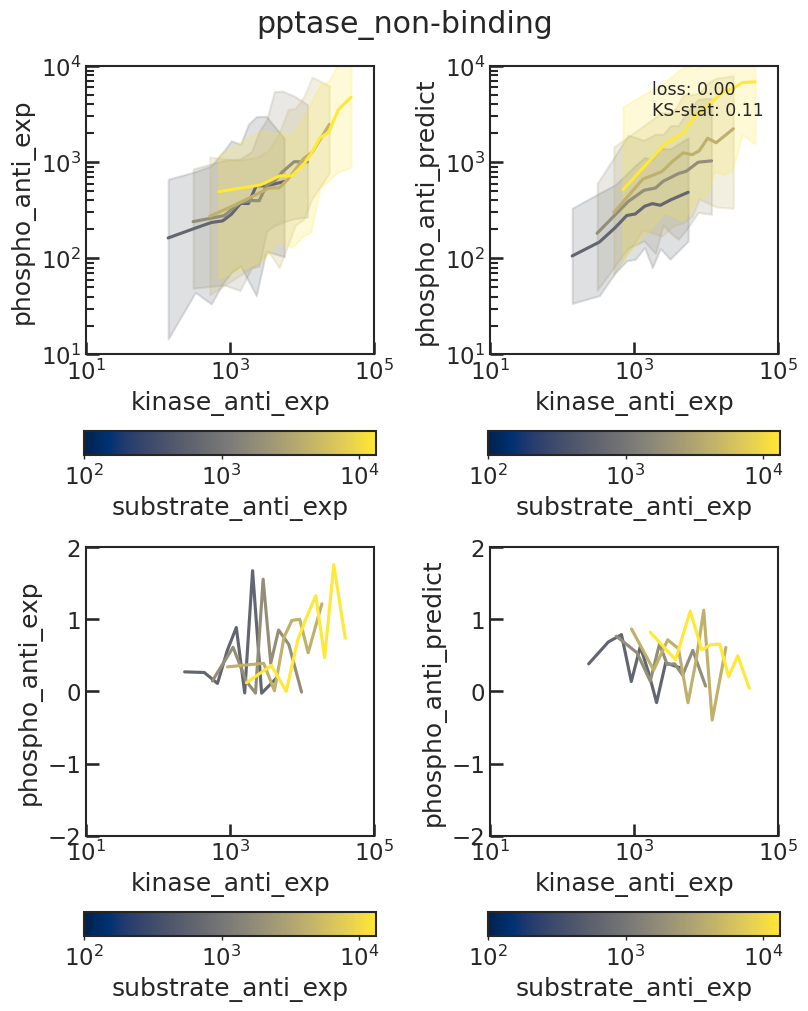

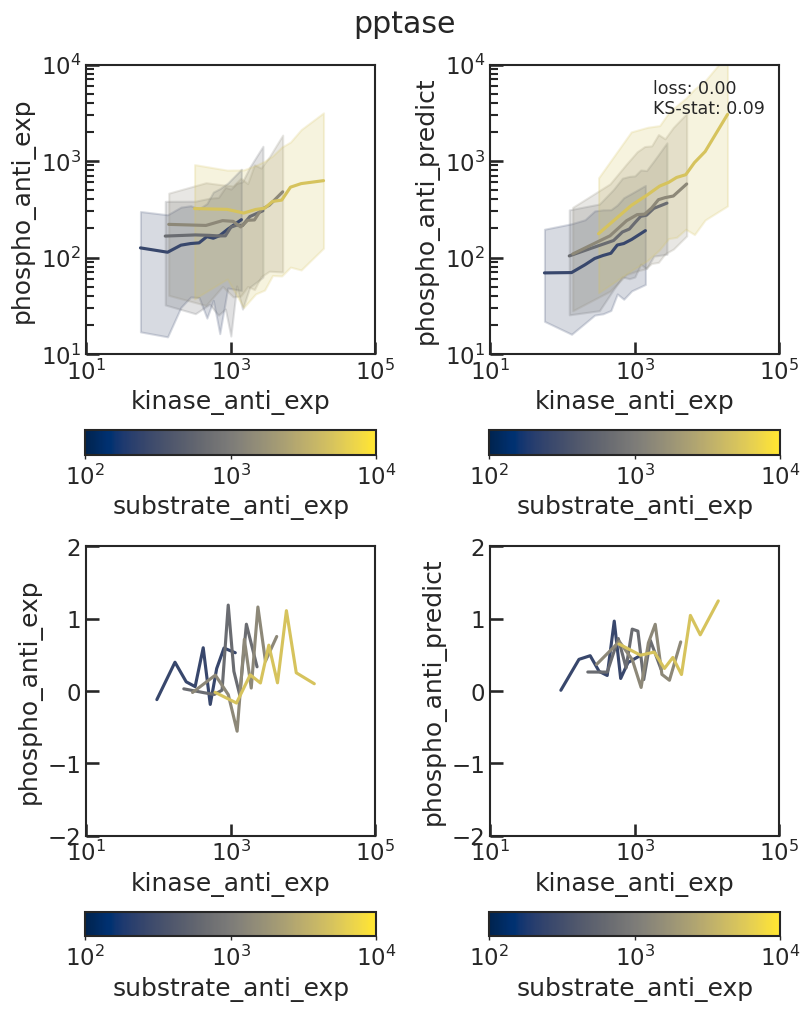

In [20]:
total_loss = np.sum((np.log10(df_data['phospho_GFP_predict'])-np.log10(df_data['phospho_GFP_infer']))**2)

print("total loss:", total_loss)

for exp_name, row in df_dataset_key.iterrows():
    
    df_tmp = df_data.query("exp_name==@exp_name")
    
    fig, axes = plt.subplots(2, 2, constrained_layout=True, figsize=(8, 10), squeeze=False)
    
#     ST_bin_edges = [1e2, 10**2.5, 1e3, 10**3.5, 1e4]
    ST_bin_edges = None
    
    fig.suptitle(exp_name)
    
    ax = axes[0, 0]
    
    fplot.plot_activation_curves(df_tmp, fig, ax, 'kinase_anti_exp', 'phospho_anti_exp', 'substrate_anti_exp', 
                             nSTbins=4, ST_bin_edges=ST_bin_edges, xlim=(1e1, 1e5), ylim=(1e1, 1e4), error_bands=True, use_median=True, error_band_range=(0.5, 0.95))
    
    ax = axes[0, 1]
    
    
    fplot.plot_activation_curves(df_tmp, fig, ax, 'kinase_anti_exp', 'phospho_anti_predict', 'substrate_anti_exp', 
                             nSTbins=4, xlim=(1e1, 1e5), ylim=(1e1, 1e4), error_bands=True, use_median=True, error_band_range=(0.5, 0.95))

    loss = np.sum((np.log10(df_tmp.query("exp_name==@exp_name")['phospho_GFP_predict'])-np.log10(df_tmp.query("exp_name==@exp_name")['phospho_GFP_infer']))**2)
    loss /= total_loss
    
    KS = row['KS_stat']
    
    ax.text(0.95, 0.95, "loss: {0:.2f}\nKS-stat: {1:0.2f}".format(loss, KS), transform=ax.transAxes, ha='right', va='top', fontsize='x-small', ma='left')
    
    
    ax = axes[1, 0]
    
    fplot.plot_sensitivity_curves(df_tmp, fig, ax, 'kinase_anti_exp', 'phospho_anti_exp', 'substrate_anti_exp', 
                             nSTbins=4, ST_bin_edges=ST_bin_edges, xlim=(1e1, 1e5), ylim=(-2, 2), use_median=True, ylog_scale=True)
    
    ax = axes[1, 1]
    
    fplot.plot_sensitivity_curves(df_tmp, fig, ax, 'kinase_anti_exp', 'phospho_anti_predict', 'substrate_anti_exp', 
                             nSTbins=4, ST_bin_edges=ST_bin_edges, xlim=(1e1, 1e5), ylim=(-2, 2), use_median=True, ylog_scale=True)
    
    plt.show()
    

    